In [ ]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_fast import TimeSeriesLoader as TimeSeriesLoaderFast
# from nixtla.data.tsloader_pinche import TimeSeriesLoader as TimeSeriesLoaderPinche
from nixtla.data.tsloader_general import TimeSeriesLoader as TimeSeriesLoaderGeneral

np.random.seed(1)

TourismInfo.groups[2] Monthly


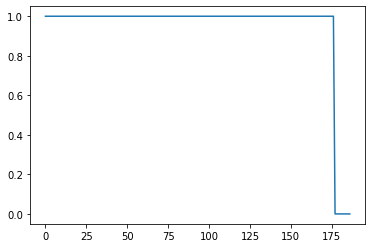

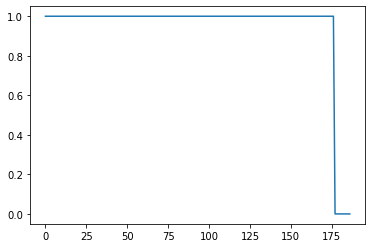

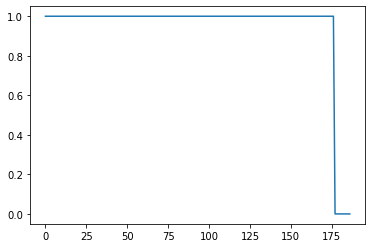

len(mask_df.unique_id.unique() 366
Train Validation splits
                              ds           
                             min        max
unique_id sample_mask                      
m1        0.0         1993-10-31 1994-07-31
          1.0         1979-01-31 1993-09-30
m10       0.0         2006-03-31 2006-12-31
          1.0         1985-01-31 2006-02-28
m100      0.0         2006-09-30 2007-06-30
...                          ...        ...
m97       1.0         1980-01-31 2006-08-31
m98       0.0         2006-09-30 2007-06-30
          1.0         1980-01-31 2006-08-31
m99       0.0         2006-09-30 2007-06-30
          1.0         1980-01-31 2006-08-31

[732 rows x 2 columns]
Total data 			109280 time stamps
Available prc = 1.0, 		109280.0 time stamps
Train prc = 0.96651, 		105620.0 time stamps
Predict prc = 0.03349, 		3660.0 time stamps




In [ ]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.tourism import Tourism, TourismInfo

group = TourismInfo.groups[2]
print("TourismInfo.groups[2]", group)
Y_df, _ = Tourism.load(directory='data', group=group)

# Creating outliers to check leakages
ds = np.sort(Y_df['ds'].unique())
ts_train_mask = np.ones(333) # hardcodeado a serie más larga
ts_train_mask[-10:] = 0
outlier = Y_df.groupby('unique_id').tail(10).reset_index(drop=True)
outlier['y'] = [10**(x+8) for x in range(10)] * len(np.unique(Y_df.unique_id))
outlier.columns = ['unique_id', 'ds', 'y_val']
Y_df = Y_df.merge(outlier, how='left', on=['unique_id', 'ds'])
Y_df['y_val'] = Y_df['y_val'].fillna(0)
Y_df['y'] = Y_df['y'] + Y_df['y_val']
del Y_df['y_val']


def get_last_n_timestamps_mask_df(Y_df, n_timestamps):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_timestamps)
    last_df['mask'] = 1

    last_df = last_df[['unique_id', 'ds', 'mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['mask'] = mask_df['mask'].fillna(0)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df



mask_df = get_last_n_timestamps_mask_df(Y_df=Y_df, n_timestamps=10)
mask_df['available_mask'] = np.ones(len(mask_df))
mask_df['sample_mask'] = (1-mask_df['mask'].values)

for u_id in ['m1', 'm100', 'm366']:
    plt.plot(range(len(mask_df[mask_df.unique_id=='m1'])),
            mask_df[mask_df.unique_id=='m1'].sample_mask)
    plt.show()

print("len(mask_df.unique_id.unique()", len(mask_df.unique_id.unique()))

tourism_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=None, mask_df=mask_df)

# groupby(['unique_id']).agg({''})

In [ ]:
ts_loader_general = TimeSeriesLoaderGeneral(ts_dataset=tourism_dataset,
                                            model='nbeats',
                                            offset=0,
                                            window_sampling_limit=tourism_dataset.max_len,
                                            input_size=3*4,
                                            output_size=4,
                                            idx_to_sample_freq=1,
                                            batch_size= 2048,
                                            n_series_per_batch=32,
                                            is_train_loader=True,
                                            shuffle=False,
                                            random_seed=1)

# ts_loader_pinche = TimeSeriesLoaderPinche(ts_dataset=tourism_dataset,
#                                           model='nbeats',
#                                           offset=0,
#                                           window_sampling_limit=200*4, 
#                                           input_size=3*4,
#                                           output_size=4,
#                                           idx_to_sample_freq=1,
#                                           batch_size= 2048,
#                                           is_train_loader=True)

ts_loader_fast = TimeSeriesLoaderFast(ts_dataset=tourism_dataset,
                                      model='nbeats',
                                      offset=0,
                                      window_sampling_limit=tourism_dataset.max_len,
                                      input_size=3*4,
                                      output_size=4,
                                      idx_to_sample_freq=1,
                                      batch_size= 2048,
                                      is_train_loader=True,
                                      shuffle=False,
                                      random_seed=1)

# ts_loader_general = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
#                                             model='nbeats',
#                                             offset=0,
#                                             window_sampling_limit=365*4*24, 
#                                             input_size=3*24,
#                                             output_size=24,
#                                             idx_to_sample_freq=1,
#                                             batch_size= 2048,
#                                             n_series_per_batch=1,
#                                             is_train_loader=True)

# # TODO: Investigar porqué el pinche escala de 0.13 a 4 segundos con exogenas EAI puede no tener la culpa
# ts_loader_pinche = TimeSeriesLoaderPinche(ts_dataset=epf_dataset,
#                                         model='nbeats',
#                                         offset=0,
#                                         window_sampling_limit=365*4*24, 
#                                         input_size=3*24,
#                                         output_size=24,
#                                         idx_to_sample_freq=1,
#                                         batch_size= 2048,
#                                         is_train_loader=True)

# ts_loader_fast = TimeSeriesLoaderFast(ts_dataset=epf_dataset,
#                                         model='nbeats',
#                                         offset=0,
#                                         window_sampling_limit=365*4*24, 
#                                         input_size=3*24,
#                                         output_size=24,
#                                         idx_to_sample_freq=1,
#                                         batch_size= 2048,
#                                         is_train_loader=True)

## COMPARING BATCH TIMES AND CHECKING MODEL INPUT SHAPES
## CHECKING VALIDATION MASK AND LEAKAGE PROTECTIONS

In [ ]:
start = time.time()
dataloader = iter(ts_loader_general)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_x = batch['outsample_x']
outsample_y = batch['outsample_y']
outsample_mask = batch['outsample_mask']
print("DataloaderGeneral batch time:", time.time()-start)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)
print("t.max(insample_y)", t.max(insample_y))
print("t.max(outsample_y)", t.max(outsample_y * outsample_mask))

DataloaderGeneral batch time: 0.008023977279663086
insample_y.shape torch.Size([7506, 12])
insample_x.shape torch.Size([7506, 0, 12])
outsample_y.shape torch.Size([7506, 4])
outsample_x.shape torch.Size([7506, 0, 4])
t.max(insample_y) tensor(153300.)
t.max(outsample_y) tensor(153300.)


In [ ]:
# start = time.time()
# dataloader = iter(ts_loader_pinche)
# batch = next(dataloader)
# insample_y = batch['insample_y']
# insample_x = batch['insample_x']
# insample_mask = batch['insample_mask']
# outsample_x = batch['outsample_x']
# outsample_y = batch['outsample_y']
# outsample_mask = batch['outsample_mask']
# print("DataloaderPinche batch time:", time.time()-start)
# print("insample_y.shape", insample_y.shape)
# print("insample_x.shape", insample_x.shape)
# print("outsample_y.shape", outsample_y.shape)
# print("outsample_x.shape", outsample_x.shape)
# print("t.max(insample_y)", t.max(insample_y))
# print("t.max(outsample_y)", t.max(outsample_y * outsample_mask))

In [ ]:
dataloader = iter(ts_loader_fast)
batch = next(dataloader)
start = time.time()
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_x = batch['outsample_x']
outsample_y = batch['outsample_y']
outsample_mask = batch['outsample_mask']
print("DataloaderFast batch time:", time.time()-start)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)
print("t.max(insample_y)", t.max(insample_y))
print("t.max(outsample_y)", t.max(outsample_y * outsample_mask))

DataloaderFast batch time: 0.0002601146697998047
insample_y.shape torch.Size([2048, 12])
insample_x.shape torch.Size([2048, 0, 12])
outsample_y.shape torch.Size([2048, 4])
outsample_x.shape torch.Size([2048, 0, 4])
t.max(insample_y) tensor(51058.)
t.max(outsample_y) tensor(51058.)


In [ ]:
# ts_loader_fast.ts_windows

In [ ]:
# ts_loader_fast.ts_windows[20000:20010]